In [45]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

In [46]:
FastCover = pd.read_csv("FastCover/results/FastCoverResults_MDH_erdos.txt", header = None)
FastCover.columns = ["graph", "n_covered","t_mean","n"]
FastCover["model"] = "GRAT"
FastCover = FastCover[["graph", "model","n_covered", "n", "t_mean"]]
FastCover.head()

,graph,model,n_covered,n,t_mean
0,ER_10000_0,GRAT,1641,10000,0.080
1,ER_10000_1,GRAT,1624,10000,0.081
2,ER_10000_2,GRAT,1629,10000,0.085
3,ER_10000_3,GRAT,1637,10000,0.082
4,ER_10000_4,GRAT,1642,10000,0.073


In [47]:
models = ['GAT', "GCN", "GraphConv", "SAGE"]
Full = pd.DataFrame()

for model in models:
    GNN = pd.read_csv(f"Models/results/{model}Results_MDH_erdos.txt", header = None)
    
    GNN.columns = ["graph", "n_covered","t_mean","n"]
    GNN["model"] = model
    GNN = GNN[["graph", "model","n_covered", "n", "t_mean"]]
    
    Full = pd.concat([Full, GNN])
Full.head()

,graph,model,n_covered,n,t_mean
0,ER_10000_0,GAT,2149,10000,0.089
1,ER_10000_1,GAT,2131,10000,0.133
2,ER_10000_2,GAT,2093,10000,0.097
3,ER_10000_3,GAT,2150,10000,0.097
4,ER_10000_4,GAT,2101,10000,0.106


In [48]:
MDH = pd.read_csv(f"MDHResults_erdos.txt", header = None)
MDH.columns = ["graph", "n_covered","t_mean","n"]
MDH["model"] = 'MDH'
MDH = MDH[["graph", "model","n_covered", "n", "t_mean"]]
MDH.head()

,graph,model,n_covered,n,t_mean
0,ER_10000_0,MDH,1632,10000,0.081
1,ER_10000_1,MDH,1635,10000,0.072
2,ER_10000_2,MDH,1643,10000,0.065
3,ER_10000_3,MDH,1623,10000,0.124
4,ER_10000_4,MDH,1624,10000,0.089


In [49]:
Full = pd.concat([Full, MDH, FastCover])
Full['ratio'] =  Full.n_covered/Full.n
Full = Full.drop_duplicates(subset=['model', 'graph'], keep='last')

In [50]:
Full = Full.sort_values(by=['n'])
Full

,graph,model,n_covered,n,t_mean,ratio
10,ER_2000_0,GCN,345,2000,0.009,0.17250
18,ER_2000_8,MDH,329,2000,0.008,0.16450
17,ER_2000_7,MDH,331,2000,0.013,0.16550
16,ER_2000_6,MDH,325,2000,0.008,0.16250
15,ER_2000_5,MDH,325,2000,0.009,0.16250
...,...,...,...,...,...,...
25,ER_50000_2,GCN,8625,50000,1.274,0.17250
24,ER_50000_1,GCN,8841,50000,1.163,0.17682
23,ER_50000_0,GCN,8700,50000,1.650,0.17400
24,ER_50000_1,MDH,8052,50000,0.931,0.16104


In [51]:
Full.model.count()

198

In [52]:
fig = px.histogram(Full, x="graph", y="n_covered",
             color='model', barmode='group',
             height=400)
fig.show()

In [53]:
Full.groupby(by = "model").mean().sort_values(by=['ratio'])

C:\Users\Jairo Enrique\AppData\Local\Temp\ipykernel_12900\1843624887.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,n_covered,n,t_mean,ratio
model,,,,
SAGE,2147.363636,13484.848485,0.228242,0.159867
MDH,2182.636364,13484.848485,0.169455,0.162547
GRAT,2206.030303,13484.848485,0.171606,0.164089
GCN,2346.363636,13484.848485,0.222364,0.172867
GraphConv,2382.424242,13484.848485,0.200000,0.177042
GAT,2802.909091,13484.848485,0.267424,0.210797


## Por mejor solución

In [54]:
models_name = Full.model.unique()
Dict = {m: i for m, i in zip(models_name, np.arange(models_name.shape[0]))}

MT = np.zeros((models_name.shape[0], models_name.shape[0]))
for graph in Full.graph.unique():
    
    Temp = np.array(Full.query(f"graph == '{graph}'").sort_values(by = "ratio", ascending = False).model)
    
    for m in range(Temp.shape[0]):

        if (m + 1) == Temp.shape[0]:
            MT[ Dict[ Temp[m] ] ][ Dict[ Temp[m] ] ] += 1
            continue
        
        for j in range(m + 1, Temp.shape[0]):
            MT[ Dict[ Temp[m] ] ][ Dict[ Temp[j] ] ] += 1
        

MT_ = MT / np.expand_dims(np.sum(MT, axis = 1), 1)
# La por filas siempre debe de dar 1 y para la probabilidad de estado estacionario, 
# se hace la transpuesta, es decir, las columnas son las deben sumar 1
MT_.sum(1)

array([1., 1., 1., 1., 1., 1.])

In [55]:
SPD_best = np.ones(MT_.shape[0])/MT_.shape[0] # initial distirbution
for _ in range(200):
    SPD_best = np.dot(MT_.T, SPD_best)
print(np.round(SPD_best,3), '\n',models_name)

[0.003 0.057 0.    0.874 0.    0.067] 
 ['GCN' 'MDH' 'GraphConv' 'SAGE' 'GAT' 'GRAT']


In [56]:
# Obtenemos el mínimo porque 
models_name[np.argsort(-SPD_best)]

array(['SAGE', 'GRAT', 'MDH', 'GCN', 'GraphConv', 'GAT'], dtype=object)

Text(0.5, 23.52222222222222, 'Mejor que')

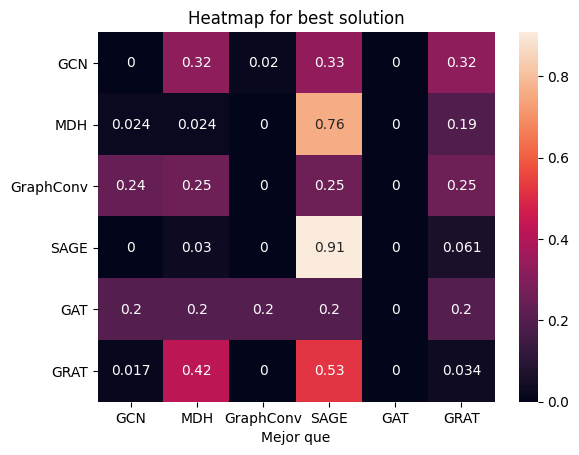

In [57]:
sns.heatmap(MT_, annot = True, xticklabels = models_name, yticklabels = models_name)
plt.title("Heatmap for best solution")
plt.xlabel("Mejor que")

## Por tiempo

In [58]:
MT = np.zeros((models_name.shape[0], models_name.shape[0]))
for graph in Full.graph.unique():
    Temp = np.array(Full.query(f"graph == '{graph}'").sort_values(by = "t_mean", ascending=False).model)
    for m in range(Temp.shape[0]):

        if (m + 1) == Temp.shape[0]:
            MT[ Dict[ Temp[m] ] ][ Dict[ Temp[m] ] ] += 1
            continue
        MT[ Dict[ Temp[m] ] ][ Dict[ Temp[m + 1] ] ] += 1

MT_ = MT / np.expand_dims(np.sum(MT, axis = 1), 1)
# La por filas siempre debe de dar 1 y para la probabilidad de estado estacionario, 
# se hace la transpuesta, es decir, las columnas son las deben sumar 1
MT_.sum(1)

array([1., 1., 1., 1., 1., 1.])

In [59]:
SPD_time = np.ones(MT_.shape[0])/MT_.shape[0] # initial distirbution
for _ in range(100):
    SPD_time = np.dot(MT_.T, SPD_time)
print(np.round(SPD_time,5), '\n',models_name)

[0.14473 0.24105 0.16527 0.15262 0.08594 0.21039] 
 ['GCN' 'MDH' 'GraphConv' 'SAGE' 'GAT' 'GRAT']


In [60]:
models_name[np.argsort(-SPD_time)]

array(['MDH', 'GRAT', 'GraphConv', 'SAGE', 'GCN', 'GAT'], dtype=object)

Text(0.5, 1.0, 'Heatmap for fastest solution')

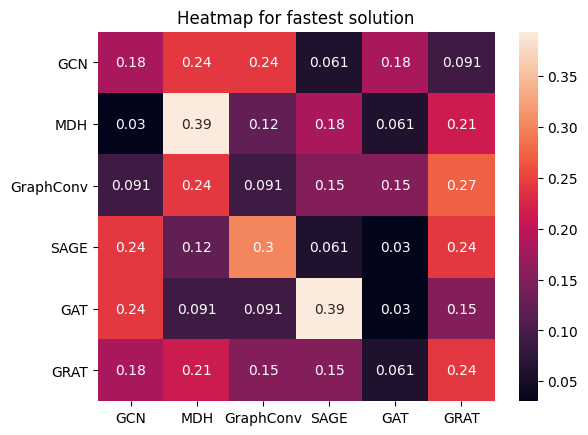

In [61]:
sns.heatmap(MT_, annot = True, xticklabels = models_name, yticklabels = models_name)
plt.title("Heatmap for fastest solution")

## All together

In [62]:
print("---- Best solution ----\n")
c = 1
for g in np.argsort(-SPD_best):
    print(c," - ", models_name[g][:6], f" \t {SPD_best[g]:.3f}")
    c += 1

---- Best solution ----

1  -  SAGE  	 0.874
2  -  GRAT  	 0.067
3  -  MDH  	 0.057
4  -  GCN  	 0.003
5  -  GraphC  	 0.000
6  -  GAT  	 0.000


In [63]:
print("------ Best time ------\n")
c = 1
for g in np.argsort(-SPD_time):
    print(c," - ", models_name[g][:6], f" \t {SPD_time[g]:.3f}")
    c+=1

------ Best time ------

1  -  MDH  	 0.241
2  -  GRAT  	 0.210
3  -  GraphC  	 0.165
4  -  SAGE  	 0.153
5  -  GCN  	 0.145
6  -  GAT  	 0.086


In [301]:
import numpy as np
x = np.array([[6.5,7], [5,3],[6,6],[7.5,8.2],[4,4], [6,7], [5,5], [5.1,5.2], [7,8], [8,8], [8,8]])
x = np.append(np.ones((11,1)),x, axis = 1)
y = np.array([6,8,7,2.5,4,10,5,7,4,12,4])

In [3]:
x

array([[1. , 6.5, 7. ],
       [1. , 5. , 3. ],
       [1. , 6. , 6. ],
       [1. , 7.5, 8.2],
       [1. , 4. , 4. ],
       [1. , 6. , 7. ],
       [1. , 5. , 5. ],
       [1. , 5.1, 5.2],
       [1. , 7. , 8. ],
       [1. , 8. , 8. ],
       [1. , 8. , 8. ]])

In [4]:
np.dot(x.T, x)

array([[ 11.  ,  68.1 ,  69.4 ],
       [ 68.1 , 439.51, 451.52],
       [ 69.4 , 451.52, 470.28]])

In [73]:
np.linalg.inv(np.dot(x.T, x))

array([[ 2.50477748, -0.61285329,  0.21877171],
       [-0.61285329,  0.31657017, -0.21350205],
       [ 0.21877171, -0.21350205,  0.1748271 ]])

In [74]:
np.dot(x.T,y)

array([ 69.5 , 432.45, 435.9 ])

In [5]:
B = np.dot(np.linalg.inv(np.dot(x.T, x)), np.dot(x.T,y))
B

array([ 4.41621859,  1.24192201, -0.91719443])

In [80]:
SST = np.dot(y,y) - (np.sum(y)**2)/11
SST

82.13636363636363

In [84]:
np.dot(B, np.dot(x.T,y))

444.19131364903933

In [81]:
SSE = np.dot(y,y) - np.dot(B, np.dot(x.T,y))
SSE

77.05868635096067

In [83]:
SSReg = SST - SSE
SSReg

5.077677285402956

In [90]:
np.dot(B, [1,10,10])

7.663494397900552

In [15]:
import torch
torch.sigmoid(torch.tensor([100]))

tensor([1.])